In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import seaborn as sns
sns.set()

def get_dist_km(dlon, lat):
    """ Convert distance from longitude to km at fixed latitude """
    dphi, theta = map(np.radians, [dlon, lat]) # convert to radians
    R = 6367
    return R * dphi * np.cos(theta)

#### Function to compute phase speed ####
def get_c(U, k, L_d):
    '''Compute phase speed from U(0), wavenumber, deformation radius (km)'''
    return U * (1 - 1/(np.sqrt(L_d**2*k**2 + 1)))

#### Previous version ####
def get_c_delta(U, k, L_d, Delta):
    '''Compute phase speed based on Delta estimate'''
    return U - Delta / (2*np.sqrt(k**2 + L_d**(-2)))

#### Convert longitude to km

In [2]:
lat = 40 # fixed latitude to use, in degrees
widths_lon     = 2 * np.array([1.25, 2.3, 1.6, 1.7, 2.05, 2.1, 2.5, 1.75, 1.7, 
                               2.05, 2.25, 2.5, .75, 2.5, 2.05])
slopes_lon_day =     np.array([.0417,.1667,.0833,.1111,.0278,.0476,.3333,.1111,
                               .0476,.0278,.0833,.3333,.1111,.3333,.1111])

widths = get_dist_km(dlon=widths_lon,     lat=lat) # convert to km
slopes = get_dist_km(dlon=slopes_lon_day, lat=lat)

#### Get theoretical curves

Use two methods of computing phase speed:
\begin{align}
    c_1 &=U(0)\left[1-\frac{1}{\sqrt{\left(L_dk\right)^2+1}}\right]\\
    c_2 &= U-\frac{\Delta}{2\sqrt{k^2+L_d^{-2}}}
\end{align}

In Equation 2, $\Delta$ is calculated as:
\begin{align*}
\Delta &= \frac{H_1+H_2}{2}\left(\frac{\zeta_1+f_0}{H_1}-\frac{\zeta_2+f_0}{H_2}\right)\\  
       &= \frac{H_1+H_2}{2H_1H_2}\left[H_2\left(\zeta_1+f_0\right)-H_1\left(\zeta_2+f\right)\right]
\end{align*}

In [3]:
use_delta = True

### Parameters for plotting
U_ms = np.array([1,1.5,2])[None,None,:]    # U(0) in m/s
lam  = np.linspace(1,500,100)[:,None,None] # range of wavelength in km
L_d  = np.array([30.])[None,:,None]        # deformation radius in km

#### Convert U from m/s to km/day and wavelength to wavenumber
U = U_ms * 3600 * 24 / 1000 # U(0) in km/day
k = 2*np.pi/lam             # wavenumber in 1/km

if not use_delta:
    ####### First version #####
    c = get_c(U, k, L_d)
else:
    ##### Alternative version: compute based on change in isotherm height ##
    H1    = 200    # height in m of 15 degree isotherm north of Gulf stream 
    H2    = 800    # ""      ""             ""         south ""     ""    ""
    zeta1 = 0      # relative vorticity to the north
    zeta2 = -zeta1 # relative vorticity to the south
    H0    = (H1+H2)/2 # characteristic depth
    omega = 2 * np.pi                           # radians per day
    f0    = 2 * omega * np.sin(np.radians(lat)) # radians per day
    Delta = H0 * ((zeta1+f0)/H1 - (zeta2+f0)/H2)
    L_d_  = 2*U/Delta
    c     = get_c(U,k,L_d=L_d_)
#     c     = get_c_delta(U,k,L_d,Delta)

#### Plot

In [5]:
L_d_

array([[[11.4094604, 17.1141906, 22.8189208]]])

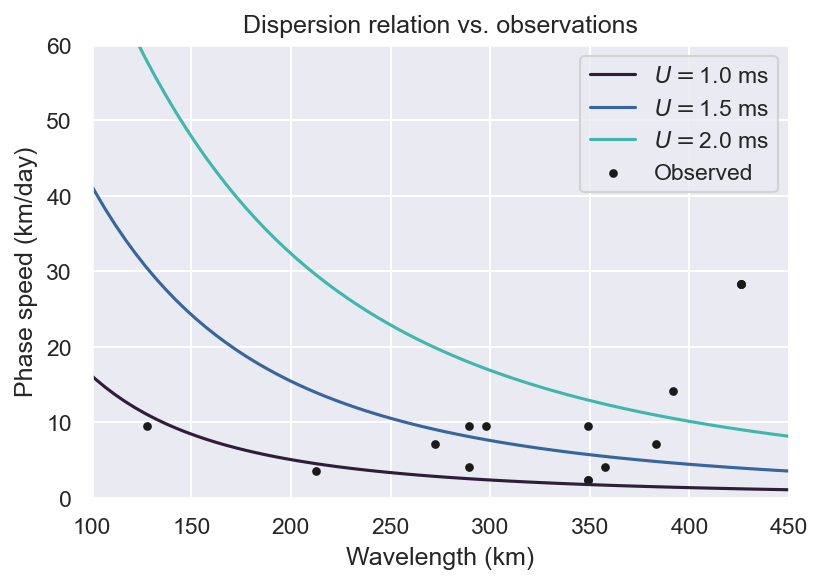

In [4]:
### colors for plotting ####
colors = sns.color_palette('mako')
fig,ax = plt.subplots()
for j,w in enumerate(U_ms.flatten()):
    for i,L in enumerate(L_d.flatten()):
        ls = '-' if i==0 else '--'
        label = r'$U=$' + f'{w} ms'
        ax.plot(lam.flatten(),c[:,i,j], label=label, c=colors[2*j], ls=ls)
ax.scatter(widths, slopes, s=10, label='Observed', c='k')
ax.set_xlabel('Wavelength (km)')
ax.set_ylabel('Phase speed (km/day)')
ax.legend()
# ax.set_title(r'Dispersion relation vs. observations ($L_d=$' + f'{L_d.item()} km)')
ax.set_title(r'Dispersion relation vs. observations')
ax.set_xlim([100,450])
ax.set_ylim([0,60])
plt.show()